# Fusion Strategies for Multisource Geospatial Data: Comparing MKL, Tabular, and Deep Learning Models​

## 1. Tabular Data Structure for Machine Learning

- Convert the tow type of tif file into csv file and make the target as a colunm to training model
- step 1 resampleing the sentinel to match the nicfi 
- step 2 merge all the data into csv file 



### 1.1 Resampling the sentinel to match the nicfi

- Nicfi scalling 5 meters and sentinel scalling 10 meters
- The shape of the nicfi and sentinel are not 2x relationship 
  - Nicfi image shape: (4, 104, 104) vs Sentinel image shape: (26, 52, 53)

#### 1.1.1 Define the resample function, resample one tif, process all the tif files, visualize the random samples

In [27]:


import os
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

def resample_sentinel(target_nicfi_path, before_sample_sentinel_path, upscaled_sentinel_path):
    """
    Resample a Sentinel image to match the size of a NICFI image using bilinear interpolation.
    
    Args:
        target_nicfi_path (str): Path to the target NICFI image
        before_sample_sentinel_path (str): Path to the Sentinel image to be resampled
        upscaled_sentinel_path (str): Path where the resampled Sentinel image will be saved
    """
    # Read the target NICFI image to get the desired dimensions
    with rasterio.open(target_nicfi_path) as nicfi_ds:
        target_height = nicfi_ds.height
        target_width = nicfi_ds.width
        target_transform = nicfi_ds.transform
        target_crs = nicfi_ds.crs

    # Read and resample the Sentinel image
    with rasterio.open(before_sample_sentinel_path) as src:
        # Calculate scaling factors
        scale_factor_x = target_width / src.width
        scale_factor_y = target_height / src.height
        
        # Create the transformation for the output
        transform = rasterio.Affine(
            target_transform.a, target_transform.b, target_transform.c,
            target_transform.d, target_transform.e, target_transform.f
        )
        
        # Perform the resampling
        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=Resampling.bilinear
        )
        
        # Create the output file with same number of bands
        output_profile = src.profile.copy()
        output_profile.update({
            'height': target_height,
            'width': target_width,
            'transform': transform,
            'crs': target_crs
        })
        
        # Write the resampled image
        with rasterio.open(upscaled_sentinel_path, 'w', **output_profile) as dst:
            dst.write(data)

def process_all_images(dev_nicfi_folder, dev_sentinel_folder, upscaled_sentinel_folder):
    """
    Process all images in the development folders.
    
    Args:
        dev_nicfi_folder (str): Path to the NICFI development folder, format: xxxx-YYYY-MM-nicfi.tif
        dev_sentinel_folder (str): Path to the Sentinel development folder, format: xxxx-YYYYMMDD-sentinel.tif
        upscaled_sentinel_folder (str): Path to save upscaled Sentinel images, format: xxxx-YYMMDD-sentinel-rs.tif
    """
    # Create output directory if it doesn't exist
    os.makedirs(upscaled_sentinel_folder, exist_ok=True)
    
    # Get list of files
    sentinel_files = sorted([f for f in os.listdir(dev_sentinel_folder) if f.endswith('-sentinel.tif')])
    nicfi_files = sorted([f for f in os.listdir(dev_nicfi_folder) if f.endswith('-nicfi.tif')])
    
    # Create dictionary of NICFI files indexed by their prefix
    nicfi_dict = {f.split('-')[0]: f for f in nicfi_files}
    
    # Process each sentinel file
    for sentinel_file in sentinel_files:
        sentinel_index = sentinel_file.split('-')[0]
        
        # Find matching NICFI file with same index
        if sentinel_index in nicfi_dict:
            nicfi_file = nicfi_dict[sentinel_index]
            sentinel_path = os.path.join(dev_sentinel_folder, sentinel_file)
            nicfi_path = os.path.join(dev_nicfi_folder, nicfi_file)
            
            # Create new filename with -rs before .tif
            base_name = os.path.splitext(sentinel_file)[0]
            upscaled_file = f"{base_name}-rs.tif"
            upscaled_path = os.path.join(upscaled_sentinel_folder, upscaled_file)
            
            print(f"Processing: {sentinel_file} with matching NICFI: {nicfi_file}")
            resample_sentinel(nicfi_path, sentinel_path, upscaled_path)
        else:
            print(f"No matching NICFI file found for Sentinel file: {sentinel_file}")

def visualize_random_samples(dev_nicfi_folder, dev_sentinel_folder, upscaled_sentinel_folder, num_samples=20):
    """
    Visualize random samples from each folder in a grid and display image information.
    
    Args:
        dev_nicfi_folder (str): Path to the NICFI development folder, format: xxxx-YYYY-MM-nicfi.tif
        dev_sentinel_folder (str): Path to the Sentinel development folder, format: xxxx-YYYYMMDD-sentinel.tif
        upscaled_sentinel_folder (str): Path to upscaled Sentinel images, format: xxxx-YYYYMMDD-sentinel-rs.tif
        num_samples (int): Number of random samples to display
    """
    # Get list of files
    sentinel_files = sorted([f for f in os.listdir(dev_sentinel_folder) if f.endswith('-sentinel.tif')])
    
    # Randomly select sentinel files
    selected_indices = random.sample(range(len(sentinel_files)), min(num_samples, len(sentinel_files)))
    
    # Create figure
    fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # Increased height for text info
    fig.suptitle('Comparison of NICFI, Original Sentinel, and Upscaled Sentinel Images', fontsize=16)
    
    # Iterate over selected indices
    for idx, file_idx in enumerate(selected_indices):
        # Calculate row and column for subplot placement
        row = idx // 5  # Integer division for row number
        col = idx % 5   # Modulo operation for column number
        
        # Get sentinel file and extract index
        sentinel_file = sentinel_files[file_idx]
        file_index = sentinel_file.split('-')[0]
        
        # Find corresponding NICFI and upscaled files
        nicfi_file = next((f for f in os.listdir(dev_nicfi_folder) 
                          if f.startswith(file_index) and f.endswith('-nicfi.tif')), None)
        upscaled_file = f"{os.path.splitext(sentinel_file)[0]}-rs.tif"
        
        if nicfi_file is None:
            print(f"No matching NICFI file found for Sentinel file: {sentinel_file}")
            continue
            
        nicfi_path = os.path.join(dev_nicfi_folder, nicfi_file)
        sentinel_path = os.path.join(dev_sentinel_folder, sentinel_file)
        upscaled_path = os.path.join(upscaled_sentinel_folder, upscaled_file)
        
        # Plot and get info for NICFI
        with rasterio.open(nicfi_path) as src:
            data = src.read(1)  # Read first band for visualization
            nicfi_info = f"NICFI: Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[row*3, col].imshow(data, cmap='viridis')
            axes[row*3, col].set_title(f'NICFI\n{Path(nicfi_file).name}', fontsize=8)
            axes[row*3, col].text(0.5, 0.95, nicfi_info, 
                                  ha='center', va='top', 
                                  transform=axes[row*3, col].transAxes,
                                  fontsize=6, wrap=True, 
                                  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            axes[row*3, col].axis('off')
        
        # Plot and get info for Original Sentinel
        with rasterio.open(sentinel_path) as src:
            # Read the full image data
            data = src.read(2)  # Read first band
            
            # Get the actual bounds
            bounds = src.bounds
            
            sentinel_info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            
            # Plot with correct bounds and no extent modification
            axes[row*3+1, col].imshow(data, 
                                    cmap='viridis',
                                    interpolation='none')  # Use 'none' to show actual pixels
            
            axes[row*3+1, col].set_title(f'Original Sentinel\n{Path(sentinel_file).name}', fontsize=8)
            axes[row*3+1, col].text(0.5, 0.95, sentinel_info,
                                    ha='center', va='top',
                                    transform=axes[row*3+1, col].transAxes,
                                    fontsize=6, color='white', bbox=dict(facecolor='black', alpha=0.5))
            axes[row*3+1, col].axis('off')
            
            # Print actual dimensions for debugging
            print(f"Sentinel image shape: {data.shape}")
        
        # Plot and get info for Upscaled Sentinel
        with rasterio.open(upscaled_path) as src:
            data = src.read(2)  # Read first band for visualization
            upscaled_info = f"Upscaled: Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[row*3+2, col].imshow(data, cmap='viridis')
            axes[row*3+2, col].set_title(f'Upscaled Sentinel\n{Path(upscaled_file).name}', fontsize=8)
            axes[row*3+2, col].text(0.5, 0.95, upscaled_info,
                                    ha='center', va='top',
                                    transform=axes[row*3+2, col].transAxes,
                                    fontsize=6, color='white', bbox=dict(facecolor='black', alpha=0.5))
            axes[row*3+2, col].axis('off')
            
            # Print detailed information to console
            print(f"\nImage Set {idx + 1}:")
            print(f"Sentinel File: {sentinel_file}")
            print(f"NICFI File: {nicfi_file}")
            print(f"Upscaled File: {upscaled_file}")
            print(nicfi_info)
            print(sentinel_info)
            print(upscaled_info)
            print("-" * 50)
    
    plt.tight_layout()



#### 1.1.2 Perform the scalling code for all the senitnel image

In [ ]:
#!!!! Time consuming
# 22 minutes for 10908 tif files

# perform the scalling code for all the senitnel image
# only do once generate the upscaled sentinel tif 
nicfi_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel'
upscaled_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_upscaled_sentinel'

process_all_images(nicfi_folder_path, sentinel_folder_path, upscaled_sentinel_folder_path)



Sentinel image shape: (21, 21)

Image Set 1:
Sentinel File: 554-20240511-sentinel.tif
NICFI File: 554-2024-03-nicfi.tif
Upscaled File: 554-20240511-sentinel-rs.tif
NICFI: Bands=4, Height=41, Width=41
Bands=26, Height=21, Width=21
Upscaled: Bands=26, Height=41, Width=41
--------------------------------------------------
Sentinel image shape: (21, 21)

Image Set 2:
Sentinel File: 39-20240321-sentinel.tif
NICFI File: 39-2024-03-nicfi.tif
Upscaled File: 39-20240321-sentinel-rs.tif
NICFI: Bands=4, Height=41, Width=41
Bands=26, Height=21, Width=21
Upscaled: Bands=26, Height=41, Width=41
--------------------------------------------------
Sentinel image shape: (21, 21)

Image Set 3:
Sentinel File: 1667-20240401-sentinel.tif
NICFI File: 1667-2024-03-nicfi.tif
Upscaled File: 1667-20240401-sentinel-rs.tif
NICFI: Bands=4, Height=41, Width=41
Bands=26, Height=21, Width=21
Upscaled: Bands=26, Height=41, Width=41
--------------------------------------------------
Sentinel image shape: (21, 22)

Image

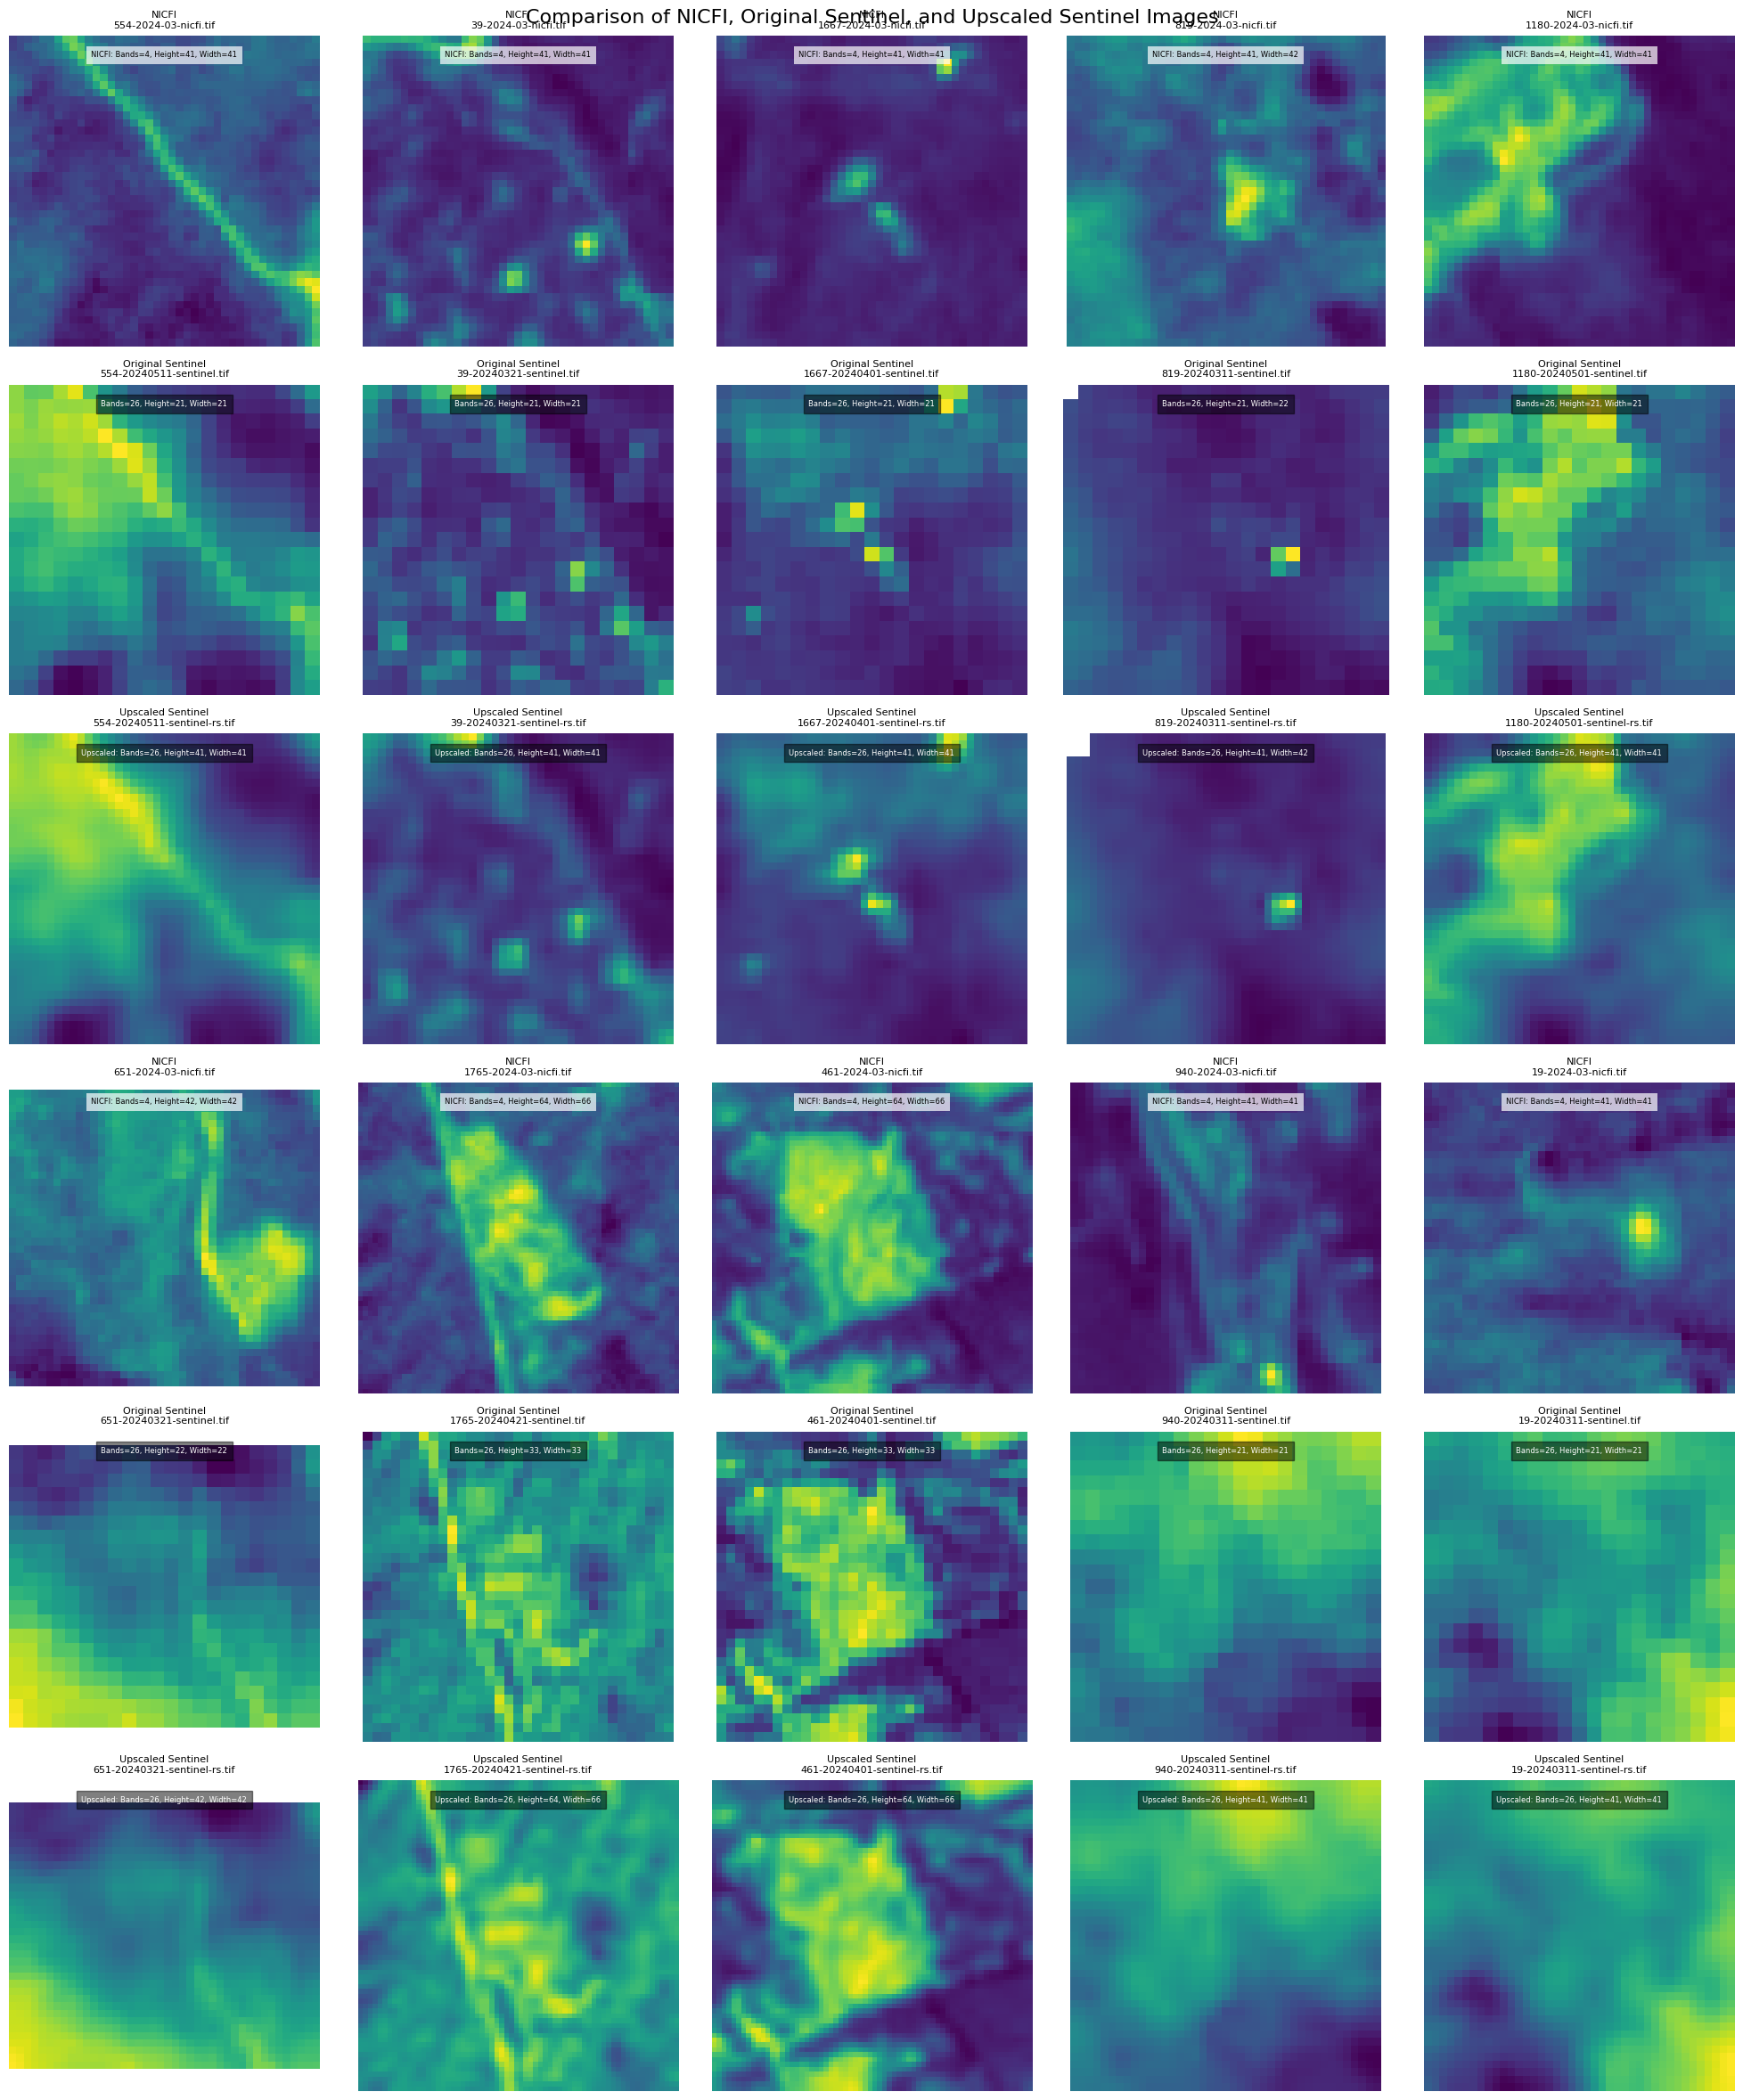

In [28]:
# show the result of the scalling
# visualize the random samples
visualize_random_samples(nicfi_folder_path, sentinel_folder_path, upscaled_sentinel_folder_path, num_samples=10)

### 1.2 Merge the nicif and upscaled sentinel and target tif into one csv file 



#### 1.2.1 check bands values for the nicfi and upscaled sentinel

In [30]:
# check the each bands size 
# randomly pick 10 tif files from the dev_nicfi and dev_upscaled_sentinel folder
# check all the bands size of these files
import random
import rasterio

import os
import random
import rasterio

def check_random_file_bands(folder_path, num_files=5):
    """
    Randomly select files from a folder and print out band information.

    Args:
        folder_path (str): Path to the folder containing the files
        num_files (int): Number of random files to check (default: 5)
    """
    # Get all .tif files in the folder
    tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    
    # Randomly select files
    selected_files = random.sample(tif_files, min(num_files, len(tif_files)))
    
    for file in selected_files:
        file_path = os.path.join(folder_path, file)
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"\nFile: {file}")
            print(f"Number of bands: {num_bands}")
            print("Band sizes:")
            for i in range(1, num_bands + 1):
                band = src.read(i)
                print(f"  Band {i}: {band.shape}")

nicfi_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
upscaled_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_upscaled_sentinel'
oruginal_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel'
check_random_file_bands(nicfi_folder_path)
check_random_file_bands(upscaled_sentinel_folder_path)
check_random_file_bands(oruginal_sentinel_folder_path)


File: 1328-2024-04-nicfi.tif
Number of bands: 4
Band sizes:
  Band 1: (41, 43)
  Band 2: (41, 43)
  Band 3: (41, 43)
  Band 4: (41, 43)

File: 677-2024-04-nicfi.tif
Number of bands: 4
Band sizes:
  Band 1: (41, 41)
  Band 2: (41, 41)
  Band 3: (41, 41)
  Band 4: (41, 41)

File: 929-2024-04-nicfi.tif
Number of bands: 4
Band sizes:
  Band 1: (41, 42)
  Band 2: (41, 42)
  Band 3: (41, 42)
  Band 4: (41, 42)

File: 1816-2024-03-nicfi.tif
Number of bands: 4
Band sizes:
  Band 1: (65, 65)
  Band 2: (65, 65)
  Band 3: (65, 65)
  Band 4: (65, 65)

File: 1207-2024-03-nicfi.tif
Number of bands: 4
Band sizes:
  Band 1: (64, 64)
  Band 2: (64, 64)
  Band 3: (64, 64)
  Band 4: (64, 64)

File: 1417-20240321-sentinel-rs.tif
Number of bands: 26
Band sizes:
  Band 1: (41, 42)
  Band 2: (41, 42)
  Band 3: (41, 42)
  Band 4: (41, 42)
  Band 5: (41, 42)
  Band 6: (41, 42)
  Band 7: (41, 42)
  Band 8: (41, 42)
  Band 9: (41, 42)
  Band 10: (41, 42)
  Band 11: (41, 42)
  Band 12: (41, 42)
  Band 13: (41, 4

Sentinel bands : 

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

| Name       | Units  | Min | Max | Scale   | Pixel Size | Wavelength                              | Description                                                                                  |
|------------|--------|-----|-----|---------|------------|------------------------------------------|----------------------------------------------------------------------------------------------|
| B1         |        |     |     | 0.0001  | 60 meters  | 443.9nm (S2A) / 442.3nm (S2B)           | Aerosols                                                                                     |
| B2         |        |     |     | 0.0001  | 10 meters  | 496.6nm (S2A) / 492.1nm (S2B)           | Blue                                                                                         |
| B3         |        |     |     | 0.0001  | 10 meters  | 560nm (S2A) / 559nm (S2B)               | Green                                                                                        |
| B4         |        |     |     | 0.0001  | 10 meters  | 664.5nm (S2A) / 665nm (S2B)             | Red                                                                                          |
| B5         |        |     |     | 0.0001  | 20 meters  | 703.9nm (S2A) / 703.8nm (S2B)           | Red Edge 1                                                                                   |
| B6         |        |     |     | 0.0001  | 20 meters  | 740.2nm (S2A) / 739.1nm (S2B)           | Red Edge 2                                                                                   |
| B7         |        |     |     | 0.0001  | 20 meters  | 782.5nm (S2A) / 779.7nm (S2B)           | Red Edge 3                                                                                   |
| B8         |        |     |     | 0.0001  | 10 meters  | 835.1nm (S2A) / 833nm (S2B)             | NIR                                                                                          |
| B8A        |        |     |     | 0.0001  | 20 meters  | 864.8nm (S2A) / 864nm (S2B)             | Red Edge 4                                                                                   |
| B9         |        |     |     | 0.0001  | 60 meters  | 945nm (S2A) / 943.2nm (S2B)             | Water vapor                                                                                  |
| B11        |        |     |     | 0.0001  | 20 meters  | 1613.7nm (S2A) / 1610.4nm (S2B)         | SWIR 1                                                                                       |
| B12        |        |     |     | 0.0001  | 20 meters  | 2202.4nm (S2A) / 2185.7nm (S2B)         | SWIR 2                                                                                       |
| AOT        |        |     |     | 0.001   | 10 meters  |                                          | Aerosol Optical Thickness                                                                   |
| WVP        | cm     |     |     | 0.001   | 10 meters  |                                          | Water Vapor Pressure. Height water would occupy if vapor condensed into liquid.              |
| SCL        |        | 1   | 11  |         | 20 meters  |                                          | Scene Classification Map ("No Data" value of 0 is masked out)                                |
| TCI_R      |        |     |     |         | 10 meters  |                                          | True Color Image, Red channel                                                               |
| TCI_G      |        |     |     |         | 10 meters  |                                          | True Color Image, Green channel                                                             |
| TCI_B      |        |     |     |         | 10 meters  |                                          | True Color Image, Blue channel                                                              |
| MSK_CLDPRB |        | 0   | 100 |         | 20 meters  |                                          | Cloud Probability Map (missing in some products)                                             |
| MSK_SNWPRB |        | 0   | 100 |         | 10 meters  |                                          | Snow Probability Map (missing in some products)                                              |
| QA10       |        |     |     |         | 10 meters  |                                          | Always empty                                                                                 |
| QA20       |        |     |     |         | 20 meters  |                                          | Always empty                                                                                 |
| QA60       |        |     |     |         | 60 meters  |                                          | Cloud mask. Masked out between 2022-01-25 to 2024-02-28 inclusive.                           |


Nicfi bands : 

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_NAIP

| **Resolution** | **4.77 meters** |
|-----------------|-----------------|

| **Name** | **Min** | **Max** | **Scale** | **Description**     |
|-----------|---------|---------|-----------|---------------------|
| B         | 0       | 10000   | 0.0001    | Blue                |
| G         | 0       | 10000   | 0.0001    | Green               |
| R         | 0       | 10000   | 0.0001    | Red                 |
| N         | 0       | 10000   | 0.0001    | Near-infrared       |



#### 1.2.2 Define merge function, merge all nicfi and upscaled sentinel and target tif into one csv file

##### 1.2.2.1 No Use Csv method 

convert 3,636 nicfle to the csv spend 1h and csv file is 12gb , not suitble for big files 

In [46]:
import pandas as pd
import numpy as np
import os
import rasterio
import geopandas as gpd


def tabularize_bands(nicfi_folder_path, upscaled_sentinel_folder_path,target_folder_path,csv_save_path):
    """
    Tabularize the bands of the NICFI and Upscaled Sentinel images.
    
    Args:
        nicfi_folder_path (str): Path to the NICFI folder, name format: xxxx-YYYY-MM-nicfi.tif
        upscaled_sentinel_folder_path (str): Path to the Upscaled Sentinel folder, name format: xxxx-YYYYMMDD-sentinel-rs.tif
        target_folder_path (str): Path to the target folder , name format: xxxx-YYYY-MM-target.tif
        csv_save_path (str): Path to save the CSV file
        csv_file_name (str): Name of the CSV file
    """

    # csv table header desgin
    # csv all the columns are from the nicfi and upscaled sentinel and the target tif 
    # for nicfi contain 4 bands
    # for upscaled sentinel contain 26 bands
    # for target contain 1 band 
    # and the upscaled sentinel have 3 tif for this month , but nicfi only have 1 tif for this month and target only have 1 tif for this month. 
    # count of the columns should have:  5 + 4 + 26 + 26 + 26 +1 = 88
    
    ccsv_columns = [
    'dp_index',  # Data point index, based on the name of the tif file xxxx-YYYY-MM-nicfi.tif xxxx is the index 
    'pixel_index',  # Pixel index , based on the order of the pixel in the tif file , using the nicfi tif , 40x40 size then from 1 to 1600 
    'date',  # Date column for the the tif, based on the name of the tif file xxxx-YYYY-MM-nicfi.tif ,using the YYYY-MM as the date
    'latitude',  # Latitude of the pixel
    'longitude',  # Longitude of the pixel
    
    # NICFI Bands
    'nicfi_band1', 'nicfi_band2', 'nicfi_band3', 'nicfi_band4', 
    
    # Sentinel Image 1 Bands
    's1_band1', 's1_band2', 's1_band3', 's1_band4', 's1_band5', 's1_band6',
    's1_band7', 's1_band8', 's1_band9', 's1_band10', 's1_band11', 's1_band12',
    's1_band13', 's1_band14', 's1_band15', 's1_band16', 's1_band17', 's1_band18',
    's1_band19', 's1_band20', 's1_band21', 's1_band22', 's1_band23', 's1_band24',
    's1_band25', 's1_band26',
    
    # Sentinel Image 2 Bands
    's2_band1', 's2_band2', 's2_band3', 's2_band4', 's2_band5', 's2_band6',
    's2_band7', 's2_band8', 's2_band9', 's2_band10', 's2_band11', 's2_band12',
    's2_band13', 's2_band14', 's2_band15', 's2_band16', 's2_band17', 's2_band18',
    's2_band19', 's2_band20', 's2_band21', 's2_band22', 's2_band23', 's2_band24',
    's2_band25', 's2_band26',
    
    # Sentinel Image 3 Bands
    's3_band1', 's3_band2', 's3_band3', 's3_band4', 's3_band5', 's3_band6',
    's3_band7', 's3_band8', 's3_band9', 's3_band10', 's3_band11', 's3_band12',
    's3_band13', 's3_band14', 's3_band15', 's3_band16', 's3_band17', 's3_band18',
    's3_band19', 's3_band20', 's3_band21', 's3_band22', 's3_band23', 's3_band24',
    's3_band25', 's3_band26',
    
    # Target Band
    'target'
    ]

    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=ccsv_columns)

    # check the csv is exist or not 
    if os.path.exists(csv_save_path):
        print(f"CSV file already exists at {csv_save_path}")
    else:
        # Create the CSV file by using the headers
        df.to_csv(csv_save_path, index=False)
        print(f"CSV file created at {csv_save_path}")


        # loop over the nicfi 
    for nicfi_file in os.listdir(nicfi_folder_path):
        nicfi_path = os.path.join(nicfi_folder_path, nicfi_file)
        nicfi_file_name = Path(nicfi_file).name # format: xxxx-YYYY-MM-nicfi.tif
        row_date = nicfi_file_name.split('-')[1] + nicfi_file_name.split('-')[2] # format: xxxx-YYYY-MM-nicfi.tif
        row_dp_index = nicfi_file_name.split('-')[0] # format: xxxx-YYYY-MM-nicfi.tif

        # Find corresponding target file
        target_file = f"{row_dp_index}-{row_date[0:4]}-{row_date[4:6]}-target.tif"
        target_path = os.path.join(target_folder_path, target_file)
        
        if not os.path.exists(target_path):
            print(f"Target file not found: {target_file}")
            continue

        # get the 3 upscaled sentinel tif files
        upscaled_sentinel_files = [f for f in os.listdir(upscaled_sentinel_folder_path) if row_dp_index==f.split('-')[0] and row_date in f]
        upscaled_sentinel_files.sort()
        
        if len(upscaled_sentinel_files) != 3:
            print(f"Error: Expected 3 upscaled sentinel files for {row_date}, but found {len(upscaled_sentinel_files)}")
            continue

        # Read NICFI data and get coordinates
        with rasterio.open(nicfi_path) as src:
            nicfi_data = src.read()  # Shape: (4, height, width)
            height, width = nicfi_data.shape[1], nicfi_data.shape[2]
            
            # Get coordinates for each pixel
            rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
            coordinates = np.stack([rows.flatten(), cols.flatten()], axis=1)
            lats, lons = [], []
            
            for coord in coordinates:
                lon, lat = src.transform * (coord[1], coord[0])
                lats.append(lat)
                lons.append(lon)

        # Read target data
        with rasterio.open(target_path) as src:
            target_data = src.read(1)  # Assuming single band target
            
        # Read sentinel data
        sentinel_data = []
        for sentinel_file in upscaled_sentinel_files:
            sentinel_path = os.path.join(upscaled_sentinel_folder_path, sentinel_file)
            with rasterio.open(sentinel_path) as src:
                sentinel_data.append(src.read())  # Shape: (26, height, width)

        # Prepare data for CSV
        rows_list = []
        pixel_index = 1  # Initialize pixel index counter

        for i in range(height):
            for j in range(width):
                row_data = {
                    'dp_index': row_dp_index,  # Add dp_index from filename
                    'pixel_index': pixel_index,  # Add sequential pixel index
                    'date': f"{row_date[0:4]}-{row_date[4:6]}",  # Format date as YYYY-MM
                    'latitude': lats[i * width + j],
                    'longitude': lons[i * width + j],
                }
                
                # Add NICFI bands
                for b in range(4):
                    row_data[f'nicfi_band{b+1}'] = nicfi_data[b, i, j]
                
                # Add Sentinel bands for each of the 3 images
                for s_idx, s_data in enumerate(sentinel_data):
                    for b in range(26):
                        row_data[f's{s_idx+1}_band{b+1}'] = s_data[b, i, j]
                
                # Add target value
                row_data['target'] = target_data[i, j]
                
                rows_list.append(row_data)
                pixel_index += 1

        # Convert to DataFrame and append to CSV
        df = pd.DataFrame(rows_list, columns=ccsv_columns)  # Use the defined column order

        # If first file, write with header, otherwise append
        if not os.path.exists(csv_save_path):
            df.to_csv(csv_save_path, index=False)
        else:
            df.to_csv(csv_save_path, mode='a', header=False, index=False)

        print(f"Processed {nicfi_file} with {len(rows_list)} pixels")



        
            



# 1h to finish about 3,636 files 
# csv will be 12.gb
        

In [48]:
import os
import time

nicfi_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
upscaled_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_upscaled_sentinel'
target_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_test_target'
csv_save_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_csv\dev_target.csv'

start_time = time.time()
# using the csv generate code
tabularize_bands(nicfi_folder_path, upscaled_sentinel_folder_path,target_folder_path,csv_save_path)

end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


CSV file created at G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_csv\dev_target.csv
Processed 0-2024-03-nicfi.tif with 1764 pixels
Processed 0-2024-04-nicfi.tif with 1764 pixels
Processed 0-2024-05-nicfi.tif with 1764 pixels
Processed 1-2024-03-nicfi.tif with 1681 pixels
Processed 1-2024-04-nicfi.tif with 1681 pixels
Processed 1-2024-05-nicfi.tif with 1681 pixels
Processed 10-2024-03-nicfi.tif with 4290 pixels
Processed 10-2024-04-nicfi.tif with 4290 pixels
Processed 10-2024-05-nicfi.tif with 4290 pixels
Processed 1000-2024-03-nicfi.tif with 1681 pixels
Processed 1000-2024-04-nicfi.tif with 1681 pixels
Processed 1000-2024-05-nicfi.tif with 1681 pixels
Processed 1001-2024-03-nicfi.tif with 1722 pixels
Processed 1001-2024-04-nicfi.tif with 1722 pixels
Processed 1001-2024-05-nicfi.tif with 1722 pixels
Processed 1002-2024-03-nicfi.tif with 4225 pixels
Processed 1002-2024-04-nicfi.tif with 4225 pixels
Processed 1002-2024-05-nicfi.tif with 4225 pixels
Processed 1004-2024-03-nicfi.tif wi

##### 1.2.2.2 Parquet method to save tabluar

| Column Name      | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `dp_index`       | Data point index, based on the name of the TIFF file `xxxx-YYYY-MM-nicfi.tif`, where `xxxx` is the index. |
| `pixel_index`    | Pixel index, based on the order of the pixel in the TIFF file, using a 40x40 NICFI TIFF (range: 1 to 1600). |
| `date`           | Date column for the TIFF, extracted from the filename `xxxx-YYYY-MM-nicfi.tif`, using `YYYY-MM` format. |
| `latitude`       | Latitude of the pixel.                                                    |
| `longitude`      | Longitude of the pixel.                                                   |
| `nicfi_band1`    | NICFI band 1.                                                             |
| `nicfi_band2`    | NICFI band 2.                                                             |
| `nicfi_band3`    | NICFI band 3.                                                             |
| `nicfi_band4`    | NICFI band 4.                                                             |
| `s1_band1`-`s1_band26` | Sentinel Image 1 bands 1 through 26.                                     |
| `s2_band1`-`s2_band26` | Sentinel Image 2 bands 1 through 26.                                     |
| `s3_band1`-`s3_band26` | Sentinel Image 3 bands 1 through 26.                                     |
| `target`         | Target band.                                                              |


In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
from pathlib import Path

def calculate_missing_percentage(data_array):
    """
    Calculate the percentage of missing (NaN) values in a given array.
    
    Args:
        data_array (np.ndarray): The data array to check for missing values.

    Returns:
        float: The percentage of missing (NaN) values.
    """
    return np.sum(np.isnan(data_array)) / data_array.size * 100

def tabularize_bands_to_parquet(nicfi_folder_path, upscaled_sentinel_folder_path, target_folder_path, parquet_save_path,caculate_missing=False):
    """
    Tabularize the bands of the NICFI and Upscaled Sentinel images without using JAX,
    and save the data in Parquet format.
    
    Args:
        nicfi_folder_path (str): Path to the NICFI folder, nicfi format: xxxx-YYYY-MM-nicfi.tif
        upscaled_sentinel_folder_path (str): Path to the Upscaled Sentinel folder, sentinel format: xxxx-YYYYMMDD-sentinel-rs.tif
        target_folder_path (str): Path to the target folder, target format: xxxx-YYYY-MM-target.tif
        parquet_save_path (str): Path to save the Parquet file.
    """
    # Column design
    parquet_columns = [
        'dp_index', 'pixel_index', 'date', 'latitude', 'longitude',
        *[f'nicfi_band{i+1}' for i in range(4)],
        *[f's{i+1}_band{j+1}' for i in range(3) for j in range(26)],
        'target'
    ]
    
    if not os.path.exists(parquet_save_path):
        # Create an empty Parquet file to start appending
        pd.DataFrame(columns=parquet_columns).to_parquet(parquet_save_path, engine='pyarrow', index=False)

    for nicfi_file in os.listdir(nicfi_folder_path):
        nicfi_path = os.path.join(nicfi_folder_path, nicfi_file)
        nicfi_file_name = Path(nicfi_file).name
        row_date = nicfi_file_name.split('-')[1] + nicfi_file_name.split('-')[2]
        row_dp_index = nicfi_file_name.split('-')[0]

        target_file = f"{row_dp_index}-{row_date[0:4]}-{row_date[4:6]}-target.tif"
        target_path = os.path.join(target_folder_path, target_file)

        if not os.path.exists(target_path):
            print(f"Target file not found: {target_file}")
            continue

        upscaled_sentinel_files = [f for f in os.listdir(upscaled_sentinel_folder_path)
                                   if row_dp_index == f.split('-')[0] and row_date in f]
        upscaled_sentinel_files.sort()

        if len(upscaled_sentinel_files) != 3:
            print(f"Expected 3 upscaled sentinel files for {row_date}, but found {len(upscaled_sentinel_files)}")
            continue

        with rasterio.open(nicfi_path) as src:
            nicfi_data = src.read()  # Shape: (4, height, width)
            height, width = nicfi_data.shape[1:]
            rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
            coords = np.stack([rows.flatten(), cols.flatten()], axis=-1)

            lats, lons = [], []
            for coord in coords:
                lon, lat = src.transform * (coord[1], coord[0])
                lats.append(lat)
                lons.append(lon)

        with rasterio.open(target_path) as src:
            target_data = np.array(src.read(1))  # Single-band target data

        sentinel_data = []
        for sentinel_file in upscaled_sentinel_files:
            with rasterio.open(os.path.join(upscaled_sentinel_folder_path, sentinel_file)) as src:
                sentinel_data.append(np.array(src.read()))  # Shape: (26, height, width)

        rows_list = []
        pixel_indices = range(height * width)

        def process_pixel(idx):
            i, j = divmod(idx, width)

            # boundary check
            if i >= height or j >= width:
                print(f"Invalid pixel index: {idx}, out of bounds")
                return
            
            # Handling missing values (NaN) in bands and target
            nicfi_values = {
                f'nicfi_band{b+1}': (nicfi_data[b, i, j] if not np.isnan(nicfi_data[b, i, j]) else None) 
                for b in range(4)
            }

            sentinel_values = {
                f's{s_idx+1}_band{b+1}': (sentinel_data[s_idx][b, i, j] if not np.isnan(sentinel_data[s_idx][b, i, j]) else None)
                for s_idx in range(3) for b in range(26)
            }

            target_value = (target_data[i, j] if not np.isnan(target_data[i, j]) else None)

            row_data = {
                'dp_index': row_dp_index,
                'pixel_index': idx + 1,
                'date': f"{row_date[0:4]}-{row_date[4:6]}",
                'latitude': lats[i * width + j],
                'longitude': lons[i * width + j],
                **nicfi_values,
                **sentinel_values,
                'target': target_value
            }
            return row_data

        # Process all pixels using a loop instead of jax.vmap
        for idx in pixel_indices:
            rows_list.append(process_pixel(idx))

        df = pd.DataFrame(rows_list, columns=parquet_columns)

        # Calculate missing data percentage for each band and target
        if caculate_missing:
            nicfi_missing = calculate_missing_percentage(nicfi_data)
            sentinel_missing = sum(calculate_missing_percentage(sentinel_band) for sentinel_band in sentinel_data) / 3
            target_missing = calculate_missing_percentage(target_data)

            
            print(f"NICFI bands missing data: {nicfi_missing}%")
            print(f"Sentinel bands missing data: {sentinel_missing}%")
            print(f"Target data missing: {target_missing}%")

        print(f"Processed {nicfi_file} with {len(rows_list)} pixels, with sentinel file{upscaled_sentinel_files}")
        # Append to Parquet file
        save_to_parquet(df, parquet_save_path)



def save_to_parquet(df, parquet_save_path):
    if os.path.exists(parquet_save_path):
        # Read the existing Parquet file
        existing_df = pd.read_parquet(parquet_save_path, engine='pyarrow')
        # Append the new data
        combined_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        combined_df = df

    # Save the combined DataFrame to Parquet
    combined_df.to_parquet(parquet_save_path, engine='pyarrow', index=False)


In [2]:

import os
import time


nicfi_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
upscaled_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_upscaled_sentinel'
target_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_test_target'
parquet_save_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_target.parquet'

start_time = time.time()

tabularize_bands_to_parquet(nicfi_folder_path, upscaled_sentinel_folder_path, target_folder_path, parquet_save_path)

end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")


Processed 0-2024-03-nicfi.tif with 1764 pixels, with sentinel file['0-20240301-sentinel-rs.tif', '0-20240311-sentinel-rs.tif', '0-20240321-sentinel-rs.tif']
Processed 0-2024-04-nicfi.tif with 1764 pixels, with sentinel file['0-20240401-sentinel-rs.tif', '0-20240411-sentinel-rs.tif', '0-20240421-sentinel-rs.tif']
Processed 0-2024-05-nicfi.tif with 1764 pixels, with sentinel file['0-20240501-sentinel-rs.tif', '0-20240511-sentinel-rs.tif', '0-20240521-sentinel-rs.tif']
Processed 1-2024-03-nicfi.tif with 1681 pixels, with sentinel file['1-20240301-sentinel-rs.tif', '1-20240311-sentinel-rs.tif', '1-20240321-sentinel-rs.tif']
Processed 1-2024-04-nicfi.tif with 1681 pixels, with sentinel file['1-20240401-sentinel-rs.tif', '1-20240411-sentinel-rs.tif', '1-20240421-sentinel-rs.tif']
Processed 1-2024-05-nicfi.tif with 1681 pixels, with sentinel file['1-20240501-sentinel-rs.tif', '1-20240511-sentinel-rs.tif', '1-20240521-sentinel-rs.tif']
Processed 10-2024-03-nicfi.tif with 4290 pixels, with sent

KeyboardInterrupt: 

#### 1.2.3 Visualize the merged tabular and correlation analysis of the data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df, target_column):
    """
    This function plots the correlation matrix and feature-target correlation for a given DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data
    - target_column: str, the name of the target column

    Returns:
    - None (Displays plots)
    """
    
    # Check if the target column exists in the dataframe
    if target_column not in df.columns:
        raise ValueError(f"The dataframe must contain a '{target_column}' column")
    
    # Compute the correlation matrix for all numerical features
    correlation_matrix = df.corr()

    # Plotting the correlation matrix for all features
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of All Features')
    plt.show()

    # For targeted correlation with the target column
    target_corr = correlation_matrix[target_column].sort_values(ascending=False)

    # Plot correlation of features with the target column
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_corr.index, y=target_corr.values, palette='viridis')
    plt.title(f'Correlation of Features with {target_column}')
    plt.xticks(rotation=90)
    plt.show()

# Example usage:
# Assuming you have a DataFrame `df` and a target column 'target'
# plot_correlation(df, 'target')


#### 1.2.4 Tabula data model training 

#### 1.2.3 Visualize and check the image

##### 1.2.3.1 Empty value is marked in red based on the nicfi image

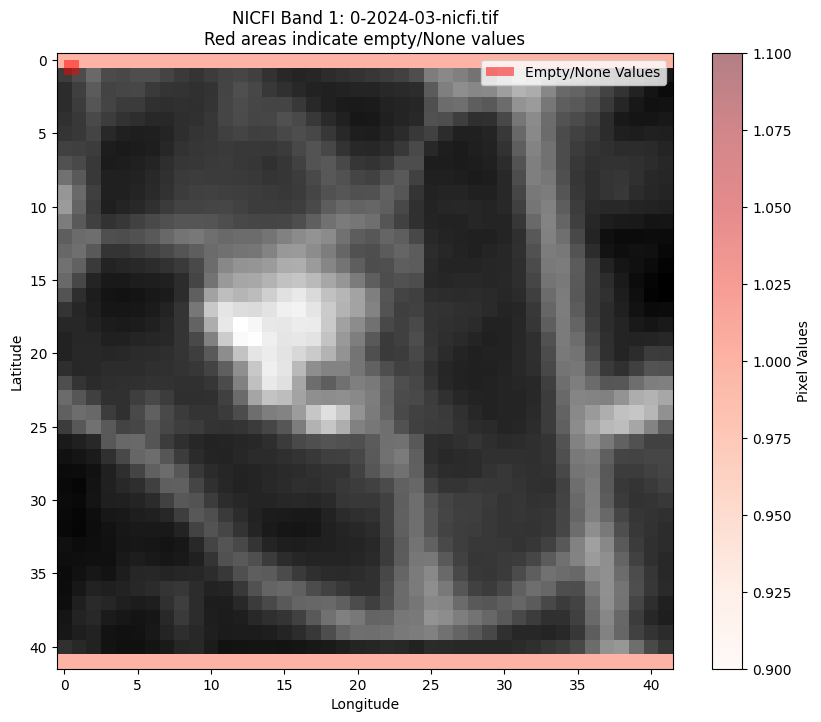

The size of the band1 of the nicfi tif file is: (42, 42)
The band1 of the nicfi tif file has non-zero value: 0-2024-03-nicfi.tif


In [13]:
# get the band1 of the nicfi tif file 
def get_band1(nicfi_path):
    with rasterio.open(nicfi_path) as src:
        nicfi_data = src.read(1)  # Single-band NICFI data
    return nicfi_data

# plot the band1 of the nicfi tif file 
def plot_band1(nicfi_path):
    """
    Plot band 1 of a NICFI tif file with empty/None values highlighted in red.
    
    Args:
        nicfi_path (str): Path to the NICFI tif file
    """
    with rasterio.open(nicfi_path) as src:
        nicfi_data = src.read(1)  # Single-band NICFI data
        
        # Create a masked array for NaN/None values
        masked_data = np.ma.masked_invalid(nicfi_data)
        
        # Create figure and axis
        plt.figure(figsize=(10, 8))
        
        # Plot valid data
        plt.imshow(masked_data, cmap='gray')
        
        # Plot NaN/None values in red
        nan_mask = np.isnan(nicfi_data)
        plt.imshow(np.where(nan_mask, 1, np.nan), cmap='Reds', alpha=0.5)
        
        # Add colorbar for valid data
        plt.colorbar(label='Pixel Values')
        
        # Add legend for NaN/None values
        red_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.5, label='Empty/None Values')
        plt.gca().add_patch(red_patch)
        plt.legend()
        
        # Add labels and title
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f"NICFI Band 1: {os.path.basename(nicfi_path)}\nRed areas indicate empty/None values")
        
        plt.show()

plot_band1(os.path.join(nicfi_folder_path,nicfi_file_name))

# show the size of the band1 of the nicfi tif file 
band1_size = get_band1(os.path.join(nicfi_folder_path,nicfi_file_name)).shape
print(f"The size of the band1 of the nicfi tif file is: {band1_size}")


# check the band1 if have none value 
def check_band1(nicfi_path):
    with rasterio.open(nicfi_path) as src:
        nicfi_data = src.read(1)  # Single-band NICFI data
        if np.isnan(nicfi_data).any():
            print(f"The band1 of the nicfi tif file has non-zero value: {os.path.basename(nicfi_path)}")
        else:
            print(f"The band1 of the nicfi tif file has no non-zero value: {os.path.basename(nicfi_path)}")

check_band1(os.path.join(nicfi_folder_path,nicfi_file_name))

## 2. CNN  for Image-Based Learning

### 2.1 Merge tif as training data 

In [ ]:
# combine 1 nicfi(4 bands) and 3 sentinel (3*26 bands) merge to one tif file with all the bands 



import os
import numpy as np
import rasterio
from pathlib import Path

def merge_nicfi_sentinel(nicfi_folder_path, upscaled_sentinel_folder_path, merged_cnn_folder_path):
    """
    Merges NICFI and Sentinel TIFF files into a single TIFF file with combined bands.

    Args:
    nicfi_folder_path (str): Path to the folder containing NICFI files with names like xxxx-YYYY-MM-nicfi.tif.
    upscaled_sentinel_folder_path (str): Path to the folder containing Sentinel files with names like xxxx-YYYYMMDD-sentinel-rs.tif.
    merged_cnn_folder_path (str): Path to the folder to save the merged files with names like xxxx-YYYY-MM-cnn.tif.
    """
    # Ensure the output folder exists
    os.makedirs(merged_cnn_folder_path, exist_ok=True)

    # List TIFF files
    nicfi_files = [f for f in os.listdir(nicfi_folder_path) if f.endswith('.tif')]
    upscaled_sentinel_files = [f for f in os.listdir(upscaled_sentinel_folder_path) if f.endswith('.tif')]

    for nicfi_file in nicfi_files:
        # Parse NICFI file details
        nicfi_path = os.path.join(nicfi_folder_path, nicfi_file)
        nicfi_file_name = Path(nicfi_file).name
        row_dp_index = nicfi_file_name.split('-')[0]  # xxxx
        nicfi_year = nicfi_file_name.split('-')[1]   # YYYY
        nicfi_month = nicfi_file_name.split('-')[2]  # MM
        row_date = f"{nicfi_year}{nicfi_month}"      # YYYYMM

        # Filter Sentinel files matching the NICFI date and index
        matching_sentinel_files = []
        for sentinel_file in upscaled_sentinel_files:
            sentinel_parts = sentinel_file.split('-')
            if len(sentinel_parts) >= 3:
                sentinel_index = sentinel_parts[0]  # xxxx
                sentinel_date = sentinel_parts[1][:6]  # YYYYMM
                if sentinel_index == row_dp_index and sentinel_date == row_date:
                    matching_sentinel_files.append(sentinel_file)

        if len(matching_sentinel_files) != 3:
            print(f"Skipping {nicfi_file}: Expected 3 matching Sentinel files, found {len(matching_sentinel_files)}.")
            continue

        # Read NICFI data
        with rasterio.open(nicfi_path) as nicfi_src:
            nicfi_data = nicfi_src.read()  # 4 bands
            meta = nicfi_src.meta  # Use NICFI metadata as the reference

        # Read Sentinel data
        sentinel_bands = []
        for sentinel_file in matching_sentinel_files:
            sentinel_path = os.path.join(upscaled_sentinel_folder_path, sentinel_file)
            with rasterio.open(sentinel_path) as sentinel_src:
                sentinel_data = sentinel_src.read()  # 26 bands per file
                sentinel_bands.append(sentinel_data)

        # Concatenate NICFI and Sentinel bands
        merged_data = np.concatenate([nicfi_data] + sentinel_bands, axis=0)  # 4 + 26*3 bands

        # Define output file name and path
        merged_file_name = f"{row_dp_index}-{nicfi_year}-{nicfi_month}-cnn.tif"
        merged_path = os.path.join(merged_cnn_folder_path, merged_file_name)

        # Write the merged file
        meta.update({
            'count': merged_data.shape[0],  # Update the band count
            'dtype': merged_data.dtype      # Ensure correct data type
        })
        with rasterio.open(merged_path, 'w', **meta) as merged_dst:
            merged_dst.write(merged_data)

        print(f"Merged {nicfi_file} with Sentinel files to {merged_file_name}, with sentinel files {matching_sentinel_files}")




In [ ]:

nicfi_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_test'
upscaled_sentinel_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_upscaled_sentinel'
merged_cnn_folder_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_cnn'


merge_nicfi_sentinel(nicfi_folder_path, upscaled_sentinel_folder_path, merged_cnn_folder_path)

### 2.2 Train the CNN model

#### 2.2.1 Define the CNN model

In [ ]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a PyTorch dataset class to load the .tif files
class TifDataset(Dataset):
    def __init__(self, train_folder, target_folder):
        self.train_files = [f for f in os.listdir(train_folder) if f.endswith('.tif')]
        self.target_files = [f for f in os.listdir(target_folder) if f.endswith('.tif')]
        self.train_folder = train_folder
        self.target_folder = target_folder

    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):
        # Get the filename for the current sample
        train_file = self.train_files[idx]
        base_name = '-'.join(train_file.split('-')[:3])  # xxxx-YYYY-MM

        # Find the corresponding target file
        target_file = f"{base_name}-target.tif"
        if target_file not in self.target_files:
            raise FileNotFoundError(f"Target file for {train_file} not found")

        # Load the train (input features) .tif file
        train_path = os.path.join(self.train_folder, train_file)
        with rasterio.open(train_path) as src:
            train_data = src.read()  # Shape: (bands, height, width)
            train_data = train_data / np.max(train_data)  # Normalize to [0, 1]
            train_data = torch.tensor(train_data, dtype=torch.float32)  # Convert to tensor

        # Load the corresponding target .tif file
        target_path = os.path.join(self.target_folder, target_file)
        with rasterio.open(target_path) as src:
            target_data = src.read(1)  # Only 1 band for target
            target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension

        return train_data, target_data

# Define the CNN model in PyTorch
class CNNModel(nn.Module):
    def __init__(self, num_bands):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(num_bands, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Flattened dimension of the output from conv layers
        self.fc2 = nn.Linear(128, 1)  # Output layer (for regression)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # Lists to store loss and accuracy values for plotting
    train_losses, val_losses = [], []
    train_mse, val_mse = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, targets.view(-1, 1))  # Reshape target for regression
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_pred = []
        val_true = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                val_loss += loss.item()
                val_pred.extend(outputs.cpu().numpy())
                val_true.extend(targets.cpu().numpy())

        # Calculate MSE and R2 score for validation
        val_mse_value = mean_squared_error(val_true, val_pred)
        val_r2_value = r2_score(val_true, val_pred)

        # Log losses and metrics
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_mse.append(running_loss / len(train_loader))  # MSE on train
        val_mse.append(val_mse_value)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val MSE: {val_mse_value:.4f}, Val R2: {val_r2_value:.4f}")

    end_time = time.time()
    print(f"Training complete. Total time: {end_time - start_time:.2f} seconds.")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label="Training Loss")
    plt.plot(range(num_epochs), val_losses, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot MSE
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_mse, label="Train MSE")
    plt.plot(range(num_epochs), val_mse, label="Validation MSE")
    plt.title("MSE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

#### 2.2.2 Train the model

In [ ]:
# Main code to load the data and train the model
train_folder = 'dev_cnn'  # Folder with training .tif files
target_folder = 'dev_test_target'  # Folder with target .tif files

# Create the dataset and dataloaders
dataset = TifDataset(train_folder, target_folder)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Instantiate the model
num_bands = len(dataset[0][0])  # Number of bands in the input data
model = CNNModel(num_bands)

# Train the model
train_model(model, train_loader, val_loader)

# Save the model
torch.save(model.state_dict(), "cnn_model.pth")


#### 2.2.3 Test the model and perform a inference

## 3. MKL (Multiple Kernel Learning) for Data Fusion